In [1]:
import tifffile
import python_test
import pandas as pd
import numpy as np
import skimage
from scipy import ndimage
from cellpose import models
import matplotlib.pyplot as plt
import os
import napari
from scipy.optimize import curve_fit
import napari_bleach_correct

In [2]:
viewer = napari.Viewer()

In [4]:
masks_path = '/home/sim/OneDrive/Data/by_projects/gcamp/masks/'
tif_path = '/home/sim/OneDrive/Data/by_projects/gcamp/tif/'
save_path = '/home/sim/OneDrive/Data/by_projects/gcamp/csvs_run2/'

def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created successfully.")
    else:
        print(f"Folder '{folder_path}' already exists.")

all_masks = os.listdir(masks_path)
create_folder(save_path)

Folder '/home/sim/OneDrive/Data/by_projects/gcamp/csvs_run2/' already exists.


In [12]:
# def do_it(X, masks, occurrence_limit=50, T=10, max_dt = 30):
import random
f = random.choice(all_masks)

X = tifffile.imread(tif_path + f)
masks = tifffile.imread(masks_path + f)
index = masks.shape[0]
X = X[:index,:,:]
viewer.add_image(X)
viewer.add_labels(masks)

<Labels layer 'masks [1]' at 0x7f42b824b580>

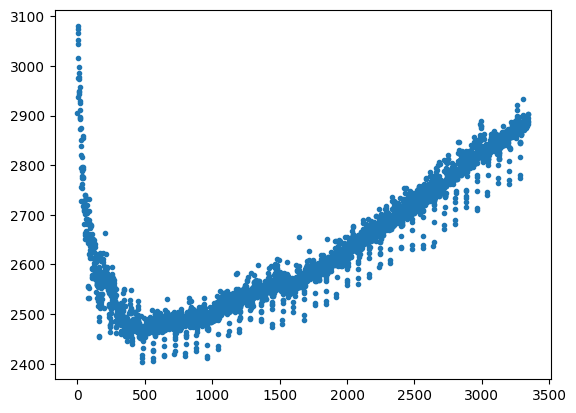

In [13]:
def histogram_equalisation(X):
    contrast_limits = napari.layers.utils.layer_utils.calc_data_range(X)
    return napari_bleach_correct.modules.histogram_correct(X, contrast_limits)

def expo_equalisation(X):
    contrast_limits = napari.layers.utils.layer_utils.calc_data_range(X)
    return napari_bleach_correct.modules.exponential_correct(X, contrast_limits)

def expo_decay(t, I0, k, c):
    return I0 * np.exp(-k * t) + c

def intensity_over_time(X):
    intensity = np.mean(X, axis=(1,2))
    plt.plot([i for i in range(len(intensity))], intensity, '.')
    plt.show()

intensity_over_time(X)

INFO:napari_bleach_correct.modules.exponential:R-squared value for fitting a mono-exponential curve: 0.38365598858466776


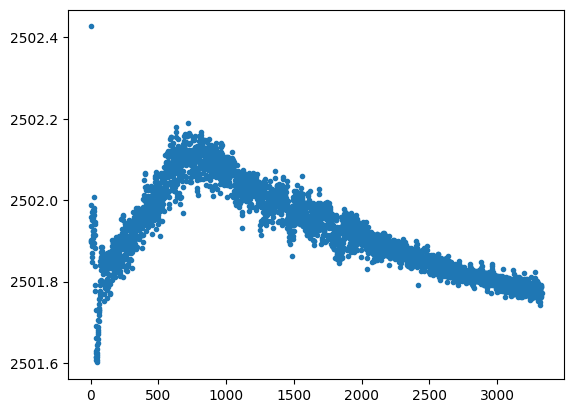

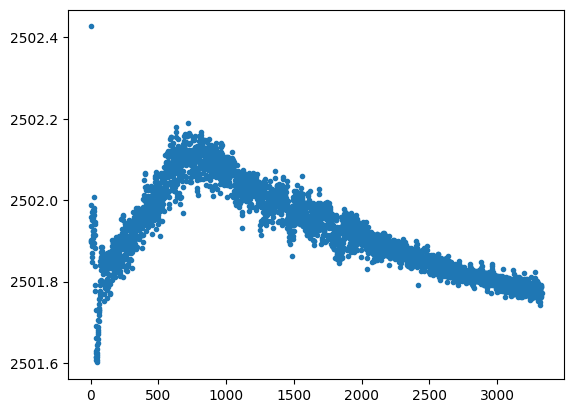

In [10]:
X_histo = histogram_equalisation(X)
X_expo = expo_equalisation(X)
intensity_over_time(X_histo)
intensity_over_time(X_expo)

In [16]:
def do_it(X, masks, occurrence_limit=50, T=10, max_dt = 30):

    # load masks
    print('Get intensities')
    common_cells, counts = python_test.get_common_cells(masks, occurrence=occurrence_limit) # Get the cells to include in the intensity measurements
    df = pd.DataFrame(columns=common_cells)     # Generate DataFrame for storing the information

    intensities = {}
    for c in common_cells:
        intensities[c] = python_test.get_cell_intensities(c, masks, X, T=T)

    row = pd.Series(intensities,name="Intensities")
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    print('Get COM')
    COMs = {}
    for c in common_cells:
        for im in range(len(masks)):
            if np.any(masks[im]==c):
                COMs[c] = list(python_test.get_centers_of_mass(masks[im], c)[0])
                break

    row = pd.Series(COMs,name="Center of mass")
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

    def filtered_masks(masks, common_cells):
        """Set all labels in masks not in common_cells to 0."""
        filter = np.isin(masks, common_cells)
        masks[~filter] = 0
        return masks

    def extract_border_values(flt_masks, cell_lbl):
        def get_border_values(mask, cell_lbl):
            padded_mask = np.pad(mask, 1, "constant", constant_values=0) # Wherever there are no neighboring cells, we 
                                                                        # want zeroes, also on edges of image
            fltr = ndimage.binary_dilation(padded_mask==cell_lbl, structure=np.ones((3, 3)))
            bv = padded_mask[fltr]
            bv = bv[bv!=cell_lbl]
            return bv

        bv_count = 10
        bv_final = []
        for m in flt_masks:
            if not np.any(m==cell_lbl):
                continue
            bv = get_border_values(m,cell_lbl)
            if not np.any(bv==0):
                return bv
            q = len(bv[bv==0])/len(bv) # Check how much of the border is 0
            if q<0.05: # We're satisfied if 95% of the border is nonzero
                return bv
            if q<bv_count:
                bv_count = q
                bv_final = bv
        return bv_final
    print('Get border values')
    fltr_masks = filtered_masks(masks, common_cells)
    border_values = {}
    for c in common_cells:
        border_values[c] = list(extract_border_values(fltr_masks, c))

    row = pd.Series(border_values,name="Border values")
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

    df.index = ['Intensities', 'Center of mass', 'Border values']

    # get cross correlation
    def get_ncc_for_bv(df, cell_lbl, max_dt):
        bvs = np.array(df.loc["Border values", cell_lbl])
        bvs = bvs[bvs!=0]
        bvs_uniq = np.unique(bvs)
        ncc = 0
        dts = 0
        for bv in bvs_uniq:
            xcorr, dt = python_test.get_cc(np.array(df.loc["Intensities", cell_lbl]),
                            np.array(df.loc["Intensities", bv]), max_dt)
            w = len(bvs[bvs==bv])/len(bvs[bvs!=0])
            ncc += np.max(xcorr)*w
            dts += dt[np.argmax(xcorr)]*w
        return ncc, dts
    print('Do Crossvalidation')
    cross_correlations = {}
    time_diffs = {}
    for c in common_cells:
        cross_correlations[c], time_diffs[c] = get_ncc_for_bv(df, c, max_dt)

    row = pd.Series(cross_correlations,name="Weighted max NCC for border values")
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    row = pd.Series(time_diffs,name="Weighted time difference at max NCC for border values")
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    df.index = ['Intensities', 'Center of mass', 'Border values', 'Weighted max NCC for border values', 'Weighted time difference at max NCC for border values']

    def get_max_freq(df, T):
        fouriermax = {}
        for c in df.columns:
            fft = np.fft.fft(df.loc["Intensities", c])
            freqs = np.fft.fftfreq(len(df.loc["Intensities", c]), T)
            fft_filtered = fft*(freqs>(3/(3600))) #Remove all periods longer than 20 min  
            fouriermax[c] = np.abs(freqs[np.argmax(fft_filtered)])
        return fouriermax

    fouriermax = get_max_freq(df, T)

    row = pd.Series(fouriermax,name="Most prominent frequency")
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    df.index = ['Intensities', 'Center of mass', 'Border values', 'Weighted max NCC for border values', 'Weighted time difference at max NCC for border values', 'Most prominent frequency']
    print('Save file')
    return df

In [17]:
list_particles = [43,28,56,49,21]
df = do_it(X, masks)
#df.to_csv(save_path + f[:-4] + '.csv')

Get intensities


/home/sim/anaconda3/envs/cuda_118/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sim/anaconda3/envs/cuda_118/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Get COM
Get border values


KeyboardInterrupt: 